# Tree based methods

In [1]:
# imports
import pandas as pd
import numpy as np
from utils import import_and_transform
from utils import get_churned_users
from utils import aggregate, aggregate_features_improved, aggregate_features_improved2
from utils import evaluate_model

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression



## Import data and apply transformations

### Train data

In [2]:
df_train = import_and_transform("Data/train.parquet")

In [3]:
user_data = import_and_transform(df_train)

In [4]:
user_data.head(1)

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,...,itemInSession,userAgent,method,length,song,artist,time,registration,session_length,song_played
0,200,NaN,Shlok,NaN,Johnson,1749042,2018-10-01 00:00:01,Logged In,NextSong,22683,...,278,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,524.32934,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-10-01 00:00:01,2018-08-08 13:22:21,11405.0,1


### Test data

In [5]:
df_test = import_and_transform("Data/test.parquet")

In [6]:
test_data = import_and_transform(df_test)

In [7]:
test_data.head(1)


,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,...,itemInSession,userAgent,method,length,song,artist,time,registration,session_length,song_played
7,200,NaN,Jonathan,NaN,Martin,1465194,2018-10-01 00:00:06,Logged In,NextSong,22483,...,29,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,250.8273,Mockingbird,Eminem,2018-10-01 00:00:06,2018-09-27 17:29:36,46790.0,1


## Aggregate data

Based on the exploratory data analysis **EDA**, we will now modify our database accordingly. The EDA showed issues and necessary changed that require database modifications.

We want to capture more temporal patterns. We want to "teach" the model to recognize churn patterns across different time periods. How do we do that?

If we look at only one point in the time, we do not have enough examples to train the model. So instead of taking just one "snapshot", we take multiple snapshots at different times and we consider each one of them as individual prediction problems. 

Like this, we increase our training data.

In [8]:
# Createing observation dates every 5 days
# Create multiple training samples with sliding window
training_dates = pd.date_range("2018-10-15", "2018-11-05", freq="5D")

X_train_list = []
y_train_list = []

# For each observ date, we create a separate training sample:
for obs_date in training_dates:
    # Filtering data up to the observation date
    df_obs = df_train[df_train["ts"] <= obs_date]
    # features = aggregate_features_improved(df_obs, obs_date)   # Better aggregate function.
    features = aggregate_features_improved2(df_obs, obs_date)  # Better function, but takes ages to run
    
    # Creating a 10 day window after the obervation date
    # And we identify who churned in that period
    window_end = obs_date + pd.Timedelta(days=10)
    churned_users = get_churned_users(df_train, obs_date, window_end)

    # 1 if they churned in the next 10 days, 0 otherwise
    labels = pd.Series(
        features.index.isin(churned_users).astype(int),
        index=features.index,
        name="churned",
    )

    X_train_list.append(features)
    y_train_list.append(labels)

    print(
        f"Date of the observation: {obs_date.date()}, with {len(features)} users, and a {labels.mean():.2%} churn rate"
    )

# We combine all observation windows:
X_train_combined = pd.concat(X_train_list)
y_train_combined = pd.concat(y_train_list)

# Drop non-numeric columns
feature_cols = X_train_combined.select_dtypes(include=[np.number]).columns
feature_cols = [
    c
    for c in feature_cols
    if c not in ["registration", "ts_min", "ts_max", "total_length"]
]

X_train_final = X_train_combined[feature_cols]

Date of the observation: 2018-10-15, with 16271 users, and a 5.08% churn rate
Date of the observation: 2018-10-20, with 17347 users, and a 4.48% churn rate
Date of the observation: 2018-10-25, with 17888 users, and a 4.49% churn rate
Date of the observation: 2018-10-30, with 18271 users, and a 4.46% churn rate
Date of the observation: 2018-11-04, with 18592 users, and a 3.78% churn rate


Let's split our data in 80% train and 20% test.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_train_final, y_train_combined, 
                                                    test_size=0.20, random_state=42)

We apply the same transformations to our test file.

In [11]:
test_features = aggregate_features_improved2(df_test, "2018-11-20")
test_submission = test_features[feature_cols]

c:\Users\andre\Documents\university\MASTER\Polytechnique\Python_for_data_science\DataScienceProject\utils.py:585: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


Let's have a look at our data now. Does it look as we want it?

In [12]:
X_train_final.head(1)

,gender,level_first,level_current,num_sessions,avg_session_length,num_songs_played,unique_artists,unique_songs,avg_song_length,days_active,...,weighted_sessions,last_session_length,has_social_activity,positive_actions,satisfaction_ratio,engagement_rate,problem_signals,ads_per_song,actions_per_session,churn_risk_score
userId,,,,,,,,,,,,,,,,,,,,,
1000025,1,0,1,11,56774.847498,1030,795,935,249.797113,12,...,4.409754,19928.0,1,121.0,0.864198,0.131911,0.0,0.00388,104.916667,2


We observe that we have our rates (very important features for our training) and everything looks as we wanted. We can now continue the project by testing different models.

## Testing out different models

### Logistic Regression

We are trying to predict 0/1 Yes/No churn. The very first intuitive step to do is to apply Logistic Regression and then optimize it.

Hence, we start by applying a vanilla Logistic Regression model.

In [13]:
log_reg = LogisticRegression(class_weight="balanced")
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.711949756704764

Confusion Matrix:
 [[12144  4733]
 [  358   439]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.72      0.83     16877
           1       0.08      0.55      0.15       797

    accuracy                           0.71     17674
   macro avg       0.53      0.64      0.49     17674
weighted avg       0.93      0.71      0.80     17674



c:\Users\andre\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
evaluate_model(log_reg, test_submission, file_out="submission-log_reg.csv")

Base predicted churn: 62.05%
Submission saved to submission-log_reg.csv


Later, we will perform hyperparameter tuning. For this, we need to note the following ideas:

In Logistic Regression, we have hyperprameters that we need to choose *before* the training so we control how the model learns. Our hyperparameters are:

- **C**: how much we penalize complexity (too high is overfitting, too low is underfitting)
- **penalty**: which type of regularization we use (l1 or l2)
- **solver**: which optimization algorithm we use

Since we do not know which combination of these 3 is the best, we need to try all of them to decide which one we'll use in the end.

For solver, we use "Liblinear", and "Saga". A solver is an optimization algorithm that finds the best model param during training. **Saga** is fast, uses low memory and is built for big data. Moreover, it uses Stochastic Average Gradient descent, meaning it updates the model parameters using small bacthes of data at time, it does not load the whole dataset in memory from the beginning, and it converges fast on big data. **Liblinear** is more reliable and is a classic choice.

**ROC-AUC** (area under the curve) measures how well the model separates the 2 classes, despite the imbalance. So in our case, it is used to answer:

"What is the probability the model will rank the churner higher if we pick one churner and one non-churner at random?"

Possible scores:

- $<0.5$ means wrose than random
- $~0.5$ means random guessing
- $1.0$ means perfect

### Decision Tree Classifier

In [15]:
clf = DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6819622043679981

Confusion Matrix:
 [[11519  5358]
 [  263   534]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.68      0.80     16877
           1       0.09      0.67      0.16       797

    accuracy                           0.68     17674
   macro avg       0.53      0.68      0.48     17674
weighted avg       0.94      0.68      0.77     17674



In [16]:
evaluate_model(clf, test_submission, file_out="submission-dt.csv")

Base predicted churn: 56.89%
Submission saved to submission-dt.csv


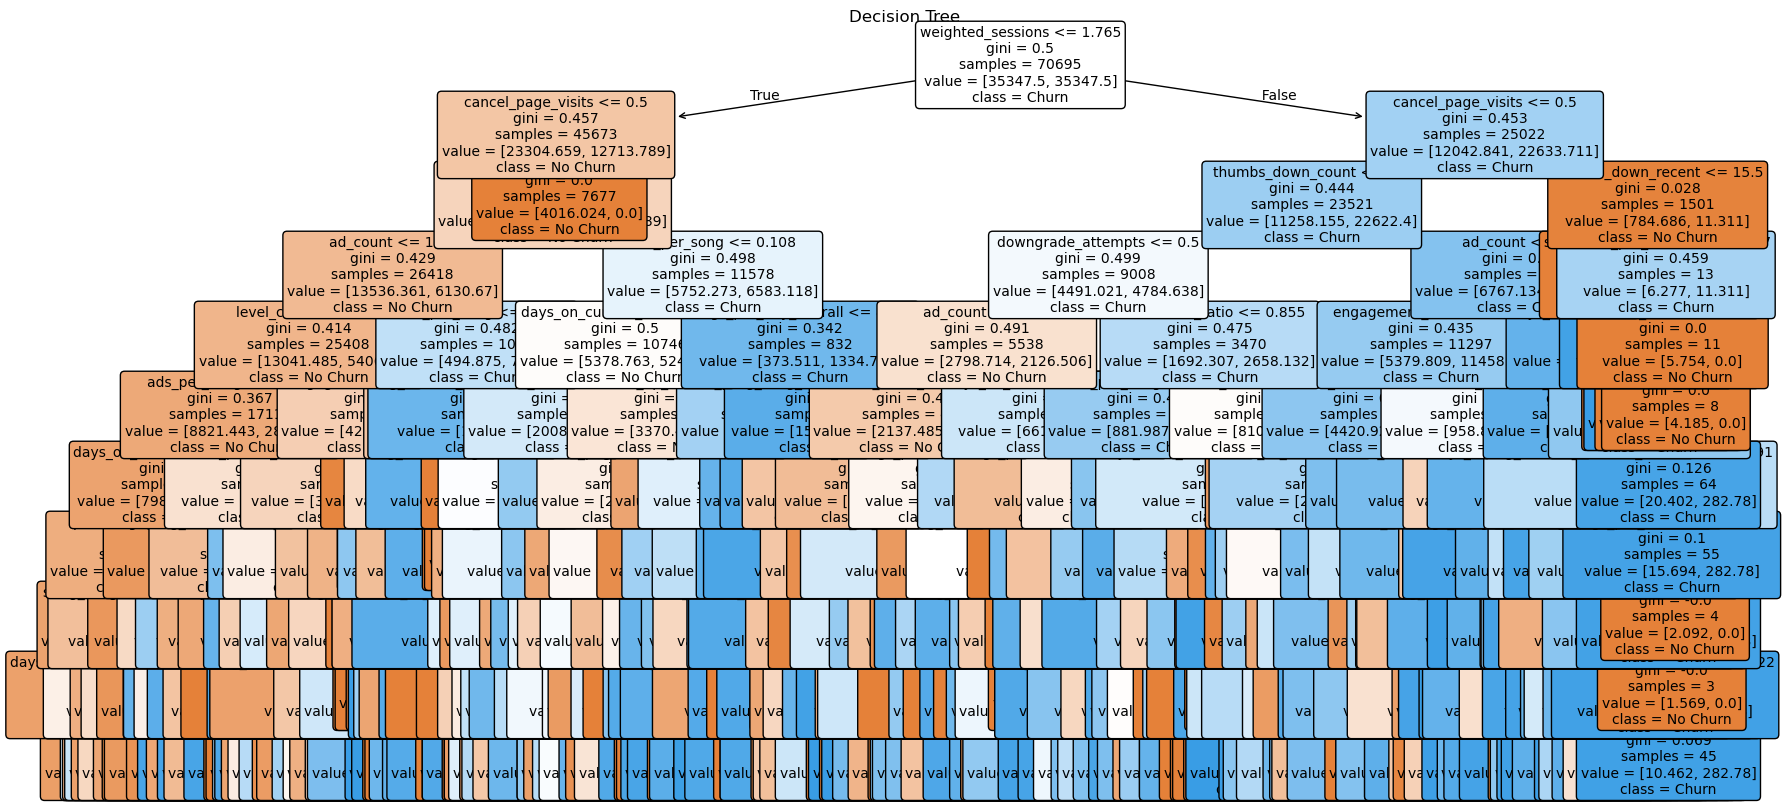

In [17]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    clf,
    feature_names=X_train.columns,
    class_names=["No Churn", "Churn"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree")
plt.show()

### XGBoost

In [18]:
import xgboost as xgb
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_ratio = neg / pos

clf = xgb.XGBClassifier(
    scale_pos_weight=scale_ratio,  # handles imbalance
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


c:\Users\andre\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:33:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[12659  4218]
 [  272   525]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.75      0.85     16877
           1       0.11      0.66      0.19       797

    accuracy                           0.75     17674
   macro avg       0.54      0.70      0.52     17674
weighted avg       0.94      0.75      0.82     17674

F1 Score: 0.18953068592057762


In [19]:
evaluate_model(clf, test_submission, file_out='submission-xgb.csv')

Base predicted churn: 46.56%
Submission saved to submission-xgb.csv


### RandomForest

In [20]:
clf = RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 6. Evaluate
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7992531402059523

Confusion Matrix:
 [[13692  3185]
 [  363   434]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.81      0.89     16877
           1       0.12      0.54      0.20       797

    accuracy                           0.80     17674
   macro avg       0.55      0.68      0.54     17674
weighted avg       0.94      0.80      0.85     17674



In [21]:
evaluate_model(model=clf, test_set=test_submission, p=0.47, file_out='submission-rf-047.csv')

Base predicted churn: 41.46%
Predicted churn at 0.47 threshold: 46.94%
Submission saved to submission-rf-047.csv


### CatBoost

In [22]:
from imblearn.over_sampling import SMOTE
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scale_pos_weight = (y_train_combined == 0).sum() / (y_train_combined == 1).sum()

cat_model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=50,
    scale_pos_weight=scale_pos_weight
)
cat_model.fit(X_train, y_train)

# Evaluate on original test set
y_pred = cat_model.predict(X_test)
y_proba = cat_model.predict_proba(X_test)[:, 1]

print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.2/102.4 MB 1.5 MB/s eta 0:01:07
   ---------------------------------------- 0.4/102.4 MB 2.7 MB/s eta 0:00:38
   ---------------------------------------- 0.4/102.4 MB 2.7 MB/s eta 0:00:38
   ---------------------------------------- 0.7/102.4 MB 2.9 MB/s eta 0:00:36
   ---------------------------------------- 0.9/102.4 MB 2.9 MB/s eta 0:00:35
   ---------------------------------------- 1.1/102.4 MB 3.2 MB/s eta 0:00:32
    --------------------------------------- 1.3/102.4 MB 3.4 MB/s eta 0:00:30
    --------------------------------------- 1.7/102.4 MB 3.7 MB/s eta 0:00:28
    --------------------------------------- 2.0/102.4 MB 4.1 MB/s eta 0:00:25
    --------------------------------------- 2.1/102.4 MB 4.0 MB/s eta 0:00:26
    --------------------------------------- 2.4/102.4 MB 3.9 MB/s eta 0:00:26


In [23]:
evaluate_model(model=cat_model, test_set=test_submission, p=0.45, file_out='submission-catb.csv')


Base predicted churn: 41.32%
Predicted churn at 0.45 threshold: 48.59%
Submission saved to submission-catb.csv


## Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from catboost import CatBoostClassifier
import numpy as np

# Calculate scale_pos_weight
scale_pos_weight = (y_train_combined == 0).sum() / (y_train_combined == 1).sum()

# Base CatBoost model
base_cat = CatBoostClassifier(
    random_seed=42,
    verbose=0,  # Suppress output during grid search
    scale_pos_weight=scale_pos_weight
)

# Parameter grid
param_grid = {
    'iterations': [200, 300, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128],
    'subsample': [0.7, 0.8, 0.9]
}

# Stratified K-Fold for imbalanced data
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid Search
print("Starting GridSearchCV...")
print(f"Total combinations: {np.prod([len(v) for v in param_grid.values()])}")
print("This may take a while...\n")

grid_search = GridSearchCV(
    estimator=base_cat,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',  # or 'roc_auc' if you prefer
    n_jobs=-1,  # Use all cores
    verbose=2
)

grid_search.fit(X_train_final, y_train_combined)

# Results
print("\n" + "="*50)
print("Best parameters:")
print(grid_search.best_params_)
print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
print("\n" + "="*50)
print("Training final model with best parameters...")
best_cat_model = CatBoostClassifier(
    **grid_search.best_params_,
    random_seed=42,
    verbose=50,
    scale_pos_weight=scale_pos_weight
)

best_cat_model.fit(X_train_final, y_train_combined)

# Predictions
cat_predictions = best_cat_model.predict(X_test)
cat_proba = best_cat_model.predict_proba(X_test)[:, 1]

print(f"\nPredicted churn rate: {cat_predictions.mean():.2%}")

# Save submission
submission = pd.DataFrame({
    'userId': test_features.index,
    'prediction': cat_predictions
})
submission.to_csv('submission_catboost_tuned.csv', index=False)
print("Submission saved: submission_catboost_tuned.csv")

# Save best parameters for future reference
import json
with open('best_catboost_params.json', 'w') as f:
    json.dump(grid_search.best_params_, f, indent=2)
print("Best parameters saved: best_catboost_params.json")